# Nettoyage des données

In [1]:
# Importation nécessaire
import pandas as pd

### Pour commencer, affichons un résumé de chaque table :

In [2]:
clients = pd.read_csv("data/clients.csv")
products = pd.read_csv("data/produits.csv")
sales = pd.read_csv("data/ventes.csv")

print("clients.csv :")
print(clients.info())
print(clients.head())
print("\nproduits.csv :")
print(products.info())
print(products.head())
print("\nventes.csv :")
print(sales.info())
print(sales.head())

clients.csv :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8623 entries, 0 to 8622
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   client_id  8623 non-null   object
 1   sex        8623 non-null   object
 2   birth      8623 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 202.2+ KB
None
  client_id sex  birth
0    c_4410   f   1967
1    c_7839   f   1975
2    c_1699   f   1984
3    c_5961   f   1962
4    c_5320   m   1943

produits.csv :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id_prod  3287 non-null   object 
 1   price    3287 non-null   float64
 2   categ    3287 non-null   int64  
dtypes: float64(1), int64(1), object(1)
memory usage: 77.2+ KB
None
  id_prod  price  categ
0  0_1421  19.99      0
1  0_1368   5.13      0
2   0_731  17.99      0
3   1_587   4.

On constate tout d'abord qu'il n'y a pas de valeurs manquantes dans ces fichiers. Partant de là, nous allons faire deux choses : étudier chaque colonne individuellement à la recherche d'éventuelles valeurs aberrantes, et déterminer si les colonnes d'id (id produit, id client, etc..) pourront être utilisées pour fusionner ces trois tables en une seule. L'objectif final est d'obtenir une unique dataframe où chaque ligne représentera une vente, ce qui nous permettra par la suite d'étudier comment chaque donnée impacte les ventes.


### clients.csv :

In [3]:
# On commence par vérifier que chaque client n'apparaît 
# qu'une fois dans la colonne client_id

# La fonction duplicated renvoit une liste de booléens qui
# indique si un id est déjà apparu plus haut dans la colonne, 
# i.e. est un doublon (True si c'est le cas, False sinon)

print(clients["client_id"].duplicated().value_counts())

False    8623
Name: client_id, dtype: int64


Il n'y a donc pas de doublons dans la colonne client_id.

In [4]:
# On vérifie ensuite que la colonne sex ne contient que 
# les lettres m et f

print(clients["sex"].value_counts())

f    4491
m    4132
Name: sex, dtype: int64


Là encore, les données sont cohérentes.

<AxesSubplot:>

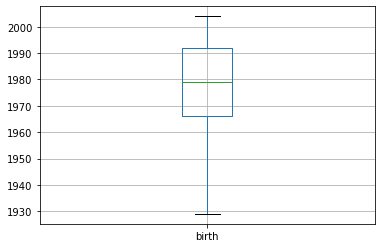

In [5]:
# Enfin, on fait un boxplot sur la colonne birth pour 
# voir si elle contient des dates illogiques

clients.boxplot(column="birth")

On remarque que le maximum se situe autour de 1930 et le maximum autour de 2005, ce qui là aussi semble cohérent.

### produits.csv :

In [6]:
# On vérifie qu chaque produit n'apparaît qu'une seule fois
print(products["id_prod"].duplicated().value_counts())

False    3287
Name: id_prod, dtype: int64


Il n'y a pas de doublons. On peut ensuite étudier la distribution des prix pour détecter d'éventuelles valeurs aberrantes :

Prix minimum :  -1.0
Prix maximum :  300.0


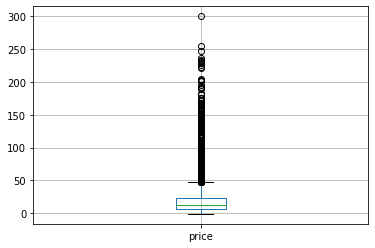

In [7]:
products.boxplot(column="price")
print("Prix minimum : ", products["price"].min())
print("Prix maximum : ", products["price"].max())

On remarque que certains produits ont des prix extrêmes pouvant aller jusqu'à 300 (la devise dans laquelle les prix sont exprimés n'est pas indiquée). Bien que cela puisse paraître incohérent au premier abord, ce n'est pas très surprenant quand on sait que certains livres anciens ou de colections peuvent se vendre plusieurs centaines d'euros.
En revanche, on constate également que certains produits ont des prix valant -1. On va donc afficher les lignes pour lesquelles c'est le cas :

In [8]:
print(products[products.price < 0])

    id_prod  price  categ
731     T_0   -1.0      0


Une seule ligne a un prix négatif : on peut donc la supprimer sans perte de données significative. On supprimera également au passage toutes les lignes contenant cet id produit dans la table sales.csv.

In [9]:
products.drop(731, axis=0, inplace=True)
products.reset_index(drop=True, inplace=True)
sales = sales[sales.id_prod != "T_0"]

Enfin, on va étudier les valeurs présentes dans la colonne categ :

0    2308
1     739
2     239
Name: categ, dtype: int64


<AxesSubplot:ylabel='Frequency'>

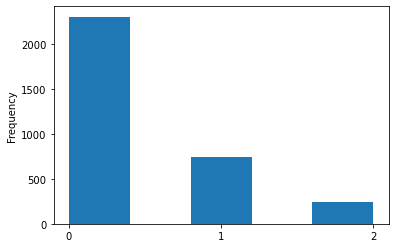

In [10]:
print(products["categ"].value_counts())
products["categ"].plot.hist(bins=5, xticks=[0, 1, 2])

On constate que les produits sont répartis en trois catégories (0, 1 et 2). Cependant, nous ne disposons d'aucune information nous permettant de comprendre à quoi correspondent ces catégories.

### ventes.csv :

Ici, on va simplement étudier le contenu de la colonne date pour vérifier qu'elle ne compte pas de valeurs aberrantes. Pour cela, on va se concentrer sur les quatre premiers caractères de la date, qui représentent l'année où a été réalisée la vente, et les afficher dans un histogramme.

2021    277933
2022     58883
Name: date, dtype: int64


<AxesSubplot:ylabel='Frequency'>

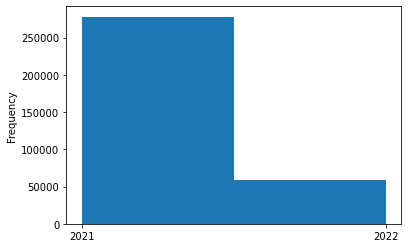

In [11]:
dates = sales["date"]
dates = dates.apply(lambda x: int(x[:4]))
print(dates.value_counts())
dates.plot.hist(bins=2, xticks=[2021, 2022])

Toutes les dates de vente sont en 2021 ou en 2022, ce qui paraît cohérent.

Nous allons maintenant pouvoir fusionner ces trois tables en une seule. Chaque ligne de la nouvelle table correspondra à une vente, à laquelle on ajoutera toutes les informations concernant le produit vendu et le client.

In [12]:
sales_and_clients = pd.merge(sales, clients, on="client_id")
final_df = pd.merge(sales_and_clients, products, on="id_prod")
print(final_df.info())
final_df.to_csv("data/merged_data.csv")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 336713 entries, 0 to 336712
Data columns (total 8 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   id_prod     336713 non-null  object 
 1   date        336713 non-null  object 
 2   session_id  336713 non-null  object 
 3   client_id   336713 non-null  object 
 4   sex         336713 non-null  object 
 5   birth       336713 non-null  int64  
 6   price       336713 non-null  float64
 7   categ       336713 non-null  int64  
dtypes: float64(1), int64(2), object(5)
memory usage: 23.1+ MB
None


Nous avons maintenant une unique dataframe prête à l'emploi qui contient toutes les informations qui nous intéressent !